In [20]:
import statistics
import sys

sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics as sm
import src.data.prepare_data as prepdata
import src.features.aggregation_helper as ha
import src.features.annotation_aggregator as aa
import src.features.tdks as d2
from sklearn.model_selection import train_test_split
from src.features.annotation_aggregator import (
    DawidSkeneAggregator,
    MaceAggregator,
    MajorityVoteAggregator,
)
from tqdm.notebook import tqdm

## Load Wulczyn / Wikipedia dataset

In [9]:
dataset_name = "Wikipedia"
(
    class_mapping,
    gold_labels,
    annotator_labels_wide,
    annotator_labels_long,
) = prepdata.get_annotator_and_gold_labels_Wikipedia()
label = class_mapping.keys()

Loaded data
----------------------------------
115864 comments
4053 annotators
2 classes: [0.0, 1.0]
----------------------------------
Running majority voting
Completed majority_voting in 0:00:01.323170 seconds



## Get bias matrices of annotators

In [10]:
annotator_ids, annotator_bias_matrices = ha.get_bias_matrix_per_annotator(
    annotator_labels_wide, gold_labels, [0.0, 1.0]
)
annotator_ids_2, annotator_bias_matrices_2 = ha.get_bias_matrix_per_annotator(
    annotator_labels_wide, gold_labels, [0.0, 1.0], normalize=None
)

In [11]:
# Transform bias matrices of annotators so that it can be converted to a dataframe
vec_length = annotator_bias_matrices.shape[1] * annotator_bias_matrices.shape[2]
annotator_bias_matrices_flattend = annotator_bias_matrices.reshape(-1, vec_length)

# Create dataframe
df_annotator_characteristics = pd.DataFrame(
    annotator_bias_matrices_flattend,
    index=annotator_ids,
    columns=["Reliability 1", "Pessimistic", "Optimistic", "Reliability 2"],
)
df_annotator_characteristics = df_annotator_characteristics.reset_index()

### Load demographic data and merge with dataframe containing the pessimistic and optimistic scores

In [12]:
df_demographics = pd.read_csv(
    "../data/raw/attack/attack_worker_demographics.tsv", sep="\t"
)

df_annotator_characteristics = df_annotator_characteristics.merge(
    df_demographics, left_on="index", right_on="worker_id", how="left"
)

df_annotator_characteristics.head()

,index,Reliability 1,Pessimistic,Optimistic,Reliability 2,worker_id,gender,english_first_language,age_group,education
0,0,0.883087,0.116913,0.056338,0.943662,0.0,male,0.0,18-30,hs
1,1,0.959828,0.040172,0.205128,0.794872,NaN,NaN,NaN,NaN,NaN
2,2,0.935632,0.064368,0.666667,0.333333,NaN,NaN,NaN,NaN,NaN
3,3,0.981857,0.018143,0.255102,0.744898,NaN,NaN,NaN,NaN,NaN
4,4,0.986058,0.013942,0.227586,0.772414,4.0,male,0.0,30-45,hs


## Select demographical features
Run only one cell of the following cells

In [13]:
demographical_feature = "education"
dem_groups = ["some", "hs", "bachelors", "masters", "doctorate", "professional"]

In [39]:
demographical_feature = "age_group"
dem_groups = ["Under 18", "18-30", "30-45", "45-60", "Over 60"]

In [30]:
demographical_feature = "english_first_language"
dem_groups = [0, 1]

In [36]:
demographical_feature = "gender"
dem_groups = ["female", "male"]

## Plot the different demographical groups according o their pessimistic and optimistic scores

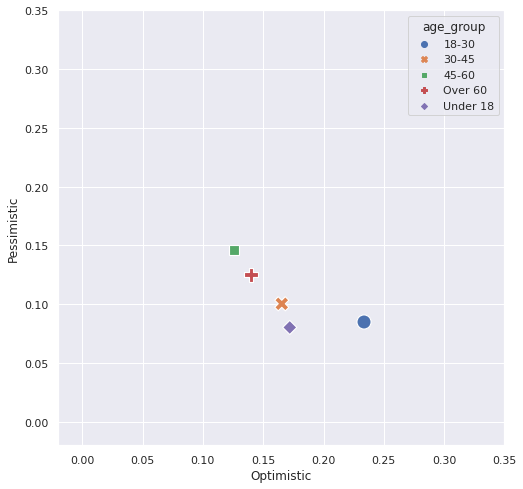

,Reliability 1,Pessimistic,Optimistic,Reliability 2,index
age_group,,,,,
18-30,0.915087,0.084913,0.233591,0.710058,1047
30-45,0.899597,0.100403,0.165416,0.799686,831
45-60,0.853937,0.146063,0.125739,0.828389,218
Over 60,0.874959,0.125041,0.139793,0.810207,20
Under 18,0.919730,0.080270,0.172038,0.692827,37


In [40]:
df_annotator_characteristics = df_annotator_characteristics[
    ~df_annotator_characteristics["worker_id"].isnull()
]
df_annotator_characteristics = df_annotator_characteristics[
    df_annotator_characteristics["gender"] != "other"
]
df_annotator_characteristics = df_annotator_characteristics[
    df_annotator_characteristics["education"] != "none"
]
df_demographics_aggregated = df_annotator_characteristics.groupby(
    demographical_feature
).agg(
    {
        "Reliability 1": "mean",
        "Pessimistic": "mean",
        "Optimistic": "mean",
        "Reliability 2": "mean",
        "index": "count",
    }
)


fig, ax = plt.subplots(figsize=(8, 8))
az = sns.scatterplot(
    ax=ax,
    data=df_demographics_aggregated,
    x="Optimistic",
    y="Pessimistic",
    # palette=["black"],
    style=demographical_feature,
    hue=demographical_feature,
    legend=True,
    s=200,
)

plt.ylim(-0.02, 0.35)
plt.xlim(-0.02, 0.35)
plt.show()

df_demographics_aggregated

## Two-dimensional version of the Kolmogorov-Smirnov test

In [53]:
results = []

# confidence level
p = 0.05

print("#"*100)
print("#"*5,"Results of the KS-test")
print("#"*100)
# run test
for i in range(len(dem_groups)):
    row = []
    for j in range(len(dem_groups)):
        dem1 = df_annotator_characteristics[
            df_annotator_characteristics[demographical_feature] == dem_groups[i]
        ][["Optimistic", "Pessimistic"]].values
        dem2 = df_annotator_characteristics[
            df_annotator_characteristics[demographical_feature] == dem_groups[j]
        ][["Optimistic", "Pessimistic"]].values
        res = d2.ks2d2s(dem1, dem2)
        flag = "Reject null hypothesis" if res[0] > p and res[1] < p else "--"
        if i <= j:
            row.append("-")
        else:
            row.append(f"{res[0]:1.3f} / {res[1]:1.3f}")
        print(
            dem_groups[i], "\t", dem_groups[j], "\t", d2.ks2d2s(dem1, dem2), "\t", flag
        )
    results.append(row)
    
print("")
print("")
# put results in one dataframe and add pessimistic / optimistic scores
df_latex = pd.DataFrame(results, index=dem_groups, columns=dem_groups)
df_latex = df_latex.iloc[:, :-1]
df_latex = df_latex.merge(
    df_demographics_aggregated[["Pessimistic", "Optimistic"]],
    left_index=True,
    right_index=True,
)

df_latex.head()

# for latex table
# print(df_latex.to_latex(float_format="{:0.3f}".format))

####################################################################################################
##### Results of the KS-test
####################################################################################################
Under 18 	 Under 18 	 (0.0, 1.0) 	 --
Under 18 	 18-30 	 (0.26141614393763385, 0.04034954953680802) 	 Reject null hypothesis
Under 18 	 30-45 	 (0.30308647998178684, 0.010988420758339338) 	 Reject null hypothesis
Under 18 	 45-60 	 (0.4353458963550707, 0.00011998657159887687) 	 Reject null hypothesis
Under 18 	 Over 60 	 (0.4162162162162162, 0.03102862623215318) 	 Reject null hypothesis
18-30 	 Under 18 	 (0.26141614393763385, 0.04034954953680802) 	 Reject null hypothesis
18-30 	 18-30 	 (0.0, 1.0) 	 --
18-30 	 30-45 	 (0.1774435468021061, 3.18595736003573e-09) 	 Reject null hypothesis
18-30 	 45-60 	 (0.3220034524153765, 4.145533542537154e-12) 	 Reject null hypothesis
18-30 	 Over 60 	 (0.3765281757402102, 0.015978320363546024) 	 Reject null hypothesis
30-45

,Under 18,18-30,30-45,45-60,Pessimistic,Optimistic
Under 18,-,-,-,-,0.080270,0.172038
18-30,0.261 / 0.040,-,-,-,0.084913,0.233591
30-45,0.303 / 0.011,0.177 / 0.000,-,-,0.100403,0.165416
45-60,0.435 / 0.000,0.322 / 0.000,0.216 / 0.000,-,0.146063,0.125739
Over 60,0.416 / 0.031,0.377 / 0.016,0.248 / 0.249,0.165 / 0.775,0.125041,0.139793
